In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# import excel file
df_test = pd.read_excel('sampledata_communitypillars.xlsx', )

In [30]:
df_test = df_test.rename(columns={0: '0.0', 0.5:'0.5', 1:'1.0'})

In [31]:
# make id column the index
df_test = df_test.set_index('id')
df_test

,0.0,0.5,1.0
id,,,
1000,1,1,1
2000,1,1,2
3000,1,1,3
4000,1,2,4
5000,1,2,5
6000,2,2,6
7000,2,2,5
8000,2,3,7


In [103]:
# create a function that takes in two lists of id numbers and returns the jaccard sim of the two lists
def calculate_difference(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    unique_1 = set1-set2
    unique_2 = set2-set1

    # Union of set1 and set 2
    union_1_2 = set1 | set2
    common = set1.intersection(set2)
    jaccard_sim = len(common) / len(union_1_2)

    return unique_1, unique_2, common, jaccard_sim

# function that takes in a partition dataframe, the modules at the base resolution, and the chi value at which to compare
def get_body_ids(df, coarse_modules, chi):
    """ This function takes in a partition dataframe, the modules at the base resolution, and the chi value at which to compare. 
    It returns a dictionary of body IDs for each cluster number at the resolution and a dictionary of body IDs for each cluster 
    number at the base resolution."""
    # Need bodyIds at zero resolution for each cluster number
    dict_zeronew= {}
    dict_zero = dict_zeronew.fromkeys(coarse_modules, [])
    for key, value in dict_zero.items():
        dict_zero[key] = df[df['0.0']==key].index.tolist()

    # Gets cluster numbers for resolution
    chi_values = [chi]
    cluster_all = np.zeros((len(coarse_modules),len(chi_values), 800))
    for i, x in enumerate(coarse_modules):
        df_test = df[df['0.0']==x]
        for f, y in enumerate(chi_values):
            cluster = df_test[y].unique()
            cluster_all[i,f, :len(cluster)] = cluster

    # move everything to a dictionary
    dict = {}
    for i, x in enumerate(coarse_modules):
        dict[coarse_modules[i]] = cluster_all[i,0]
    
    # Remove the zeros from the array
    for key, value in dict.items():
        dict[key] = value[value != 0]
        dict[key] = np.array(value, dtype='int64')
    
    # Get bodyIDs for each cluster number in the resolution
    dict_new = dict.fromkeys(coarse_modules, [])
    for key, value in dict.items():
        body_ids = []
        for i, x in enumerate(value):
            body_ids.extend(df[df[chi]==x].index.tolist())
        dict_new[key] = body_ids

    return dict_new, dict_zero
    
# Function that takes in partition dataframe, the modules at the base resolution, and the chi value at which to compare
def main_jaccard(df, coarse_modules, chi):
    """ This function takes in a partition dataframe, the modules at the base resolution, and the chi 
    value at which to compare. It returns a dataframe of the jaccard similarities between the resolutions at each cluster"""

    # Get the body IDs for each cluster number at the resolution and the base resolution
    dict_new, dict_zero = get_body_ids(df, coarse_modules, chi)
    print(dict_new.keys())
    print(dict_zero.keys())
    print(dict_new[3])
    # Create a dictionary to store the jaccard similarities
    jaccard_dict = {}
    for key, value in dict_new.items():
        jaccard_dict[key] = []
        unique_1, unique_2, common, jaccard_sim = calculate_difference(dict_new[key], dict_zero[key])
        jaccard_dict[key].append(jaccard_sim)
    
    # Create a dataframe to store the jaccard similarities
    df_jaccard = pd.DataFrame(jaccard_dict)
    df_jaccard.index = np.arange(1, len(df_jaccard)+1)
    
    return df_jaccard, dict_new, dict_zero

In [56]:
coarse_modules = [1, 2]
jaccard_values, dict_new, dict_zero = main_jaccard(df_test, coarse_modules, '0.5')

In [34]:
jaccard_values1, dict_new1, dict_zero1 = main_jaccard(df_test, coarse_modules, '1.0')

In [35]:
jaccard_values = jaccard_values._append(jaccard_values1)
jaccard_values = jaccard_values.T
jaccard_values.columns = ['0.5','1.0']
jaccard_values

,0.5,1.0
1,0.714286,0.833333
2,0.600000,0.750000


Text(0.5, 1.0, 'Jaccard Similarity between 0.0 and 0.1, 0.25')

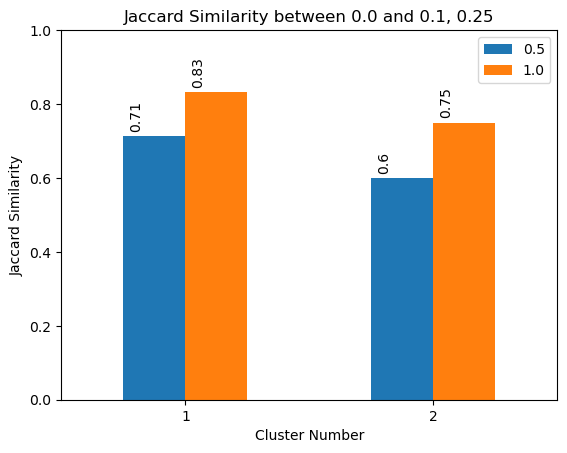

In [36]:
fig, ax  = plt.subplots()
jaccard_values.plot(kind='bar', ax=ax)

# annotate with value of each bar from jaccard_values dataframe
for i, v in enumerate(jaccard_values['0.5']):
    ax.text(i-0.2, v+.02, round(v, 2), color='black', ha='center', rotation=90)
for i, v in enumerate(jaccard_values['1.0']):
    ax.text(i+0.05, v+.02, round(v, 2), color='black', ha='center', rotation=90)
ax.set_ylim(0, 1)
ax.set_xticklabels(['1', '2'], rotation=0)
ax.set_xlabel('Cluster Number')
ax.set_ylabel('Jaccard Similarity')
ax.set_title('Jaccard Similarity between 0.0 and 0.1, 0.25')

In [37]:
dict_zero, dict_new

({1: [1000, 2000, 3000, 4000, 5000], 2: [6000, 7000, 8000]},
 {1: [1000, 2000, 3000, 4000, 5000, 6000, 7000],
  2: [4000, 5000, 6000, 7000, 8000]})

In [38]:
dict_zero1, dict_new1

({1: [1000, 2000, 3000, 4000, 5000], 2: [6000, 7000, 8000]},
 {1: [1000, 2000, 3000, 4000, 5000, 7000], 2: [6000, 5000, 7000, 8000]})

In [39]:
# Copy df_test
df_test1 = df_test.copy()

In [45]:
df_test1

,0.0,0.5,1.0
id,,,
1000,1,1,1
2000,1,1,2
3000,1,1,3
4000,1,2,4
5000,1,2,5
6000,2,2,6
7000,2,2,5
8000,2,3,7


In [26]:
# check if an id has 1 in 0.0 
list_remove= []
for i in range(len(coarse_modules)):
    list = dict_new1[i+1]

    # filter df_test to only include rows with id in list
    filter_df = df_test[df_test.index.isin(list)]
    print(filter_df)

    # check if anything but the current cluster number is in 0.0
    for index, row in filter_df.iterrows():
        if row['0.0'] != i+1:
            #find the module number for that id and add it to a list, from column 1.0
            list_remove.append(row['1.0'])

    # Remove the module's bodyIds from original dataframe
    # Any bodyIds with a 1.0 module number in list_remove should be removed from the dataframe
    df_test = df_test[~df_test['1.0'].isin(list_remove)]
    print(df_test)

      0.0  0.5  1.0
id                 
1000    1    1    1
2000    1    1    2
3000    1    1    3
4000    1    2    4
5000    1    2    5
7000    2    2    5
      0.0  0.5  1.0
id                 
1000    1    1    1
2000    1    1    2
3000    1    1    3
4000    1    2    4
6000    2    2    6
8000    2    3    7
      0.0  0.5  1.0
id                 
6000    2    2    6
8000    2    3    7
      0.0  0.5  1.0
id                 
1000    1    1    1
2000    1    1    2
3000    1    1    3
4000    1    2    4
6000    2    2    6
8000    2    3    7


In [25]:
list_remove

[5, 5]

In [130]:
df_in1 = pd.read_csv('oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv', index_col=0)
# Main function for the full process of jaccard similarity


In [139]:
# Run jaccard sim on input dataframe
chi_vals = ['0.1', '0.25', '0.5', '0.75', '1.0']
coarse_modules = [1, 2, 3, 4, 5]
zero_mods = [1, 2, 3, 4, 5]
jaccard_values, dict_new, dict_zero = main_jaccard(df_in1, coarse_modules, '0.05')
jaccard_25, dict_new, dict_zero = main_jaccard(df_in1, coarse_modules, '0.1')
jaccard_5, dict_new, dict_zero = main_jaccard(df_in1, coarse_modules, '0.5')
jaccard_75, dict_new, dict_zero = main_jaccard(df_in1, coarse_modules, '0.75')
jaccard1, dict_new, dict_zero = main_jaccard(df_in1, coarse_modules, '1.0')

# Combine the two dataframes and switch the rows and columns
jaccard_values_ins = jaccard_values._append([jaccard_25, jaccard_5, jaccard_75, jaccard1])
jaccard_values_ins = jaccard_values_ins.T
jaccard_values_ins.columns = ['0.05','0.1','0.5', '0.75', '1.0']
jaccard_values_ins

dict_keys([1, 2, 3, 4, 5])
dict_keys([1, 2, 3, 4, 5])
[1008024276, 1008369339, 1008391068, 1008693605, 1009371535, 1009578838, 1010044978, 1010437434, 1013757060, 1013779115, 1014102651, 1014223948, 1014457195, 1014461486, 1014465452, 1014465588, 1014465666, 1014474192, 1014824204, 1035393986, 1039063931, 1039068185, 1039085109, 1039400642, 1039426238, 1039754434, 1041071176, 1041075688, 1042116109, 1044459902, 1044800536, 1044805646, 1044918145, 1045141938, 1045268099, 1048975307, 1066516552, 1070103072, 1070103331, 1070422316, 1071121755, 1071496918, 1071760480, 1071769518, 1072455791, 1072503099, 1072507501, 1072533980, 1072779298, 1072779568, 1072874511, 1075598224, 1075611602, 1076185604, 1076198559, 1100801188, 1101142083, 1102191395, 1102795781, 1102804327, 1104155212, 1106888382, 1107566171, 1107566252, 1132168616, 1132168736, 1132176882, 1133562752, 1133839128, 1134849078, 1135881013, 1135898324, 1135941181, 1135941581, 1135984965, 1136252170, 1138026774, 1163552692, 116454578

,0.05,0.1,0.5,0.75,1.0
1,0.239281,0.264661,0.607018,0.683794,0.641533
2,0.380649,0.385984,0.576026,0.695821,0.793792
3,0.334855,0.268037,0.563881,0.702153,0.680974
4,0.187461,0.155031,0.483200,0.680180,0.563433
5,0.236408,0.215839,0.507208,0.651515,0.569956


Text(0.5, 1.0, 'Jaccard Similarity of Clusters as Resolution Changes')

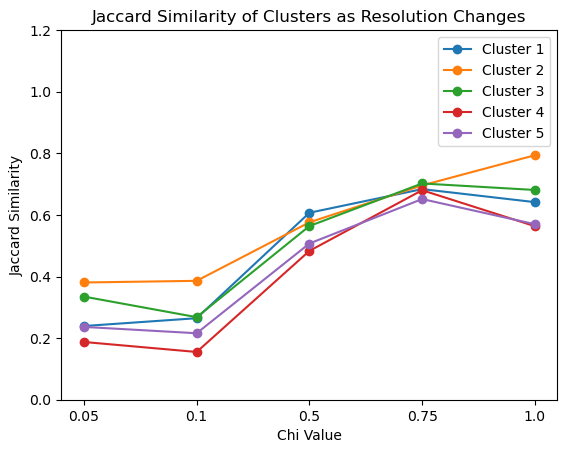

In [140]:
# Plot
fig, ax  = plt.subplots()
for i in range(0, 5):
    ax.plot(jaccard_values_ins.columns, jaccard_values_ins.iloc[i], marker = "o", label=f'Cluster {i+1}')

ax.set_ylim(0, 1.2)
ax.legend()
ax.set_ylabel('Jaccard Similarity')
ax.set_xlabel('Chi Value')
ax.set_title('Jaccard Similarity of Clusters as Resolution Changes')

In [90]:
# function that repeats the process of calculating jaccard similarity and removing bodyIds from the dataframe
def pillar_finder(df, coarse_modules, chi_vals):
    """ This function takes in a partition dataframe, the modules at the base resolution and the chi values at 
    which to compare. It returns a dataframe filtered to only include bodyIds that produce high jaccard similarity
    between the resolutions."""
    # Jaccard tracking dataframe
    jaccard_track = pd.DataFrame()
    # Increments through the chi values given
    for chi in chi_vals:

        # Calculate the jaccard similarity and create dicts of bodyIds
        jaccard_values, dict_new, dict_zero = main_jaccard(df, coarse_modules, chi)
        (print(jaccard_values))
        # Append the jaccard values to the dataframe
        jaccard_track = jaccard_track._append(jaccard_values)

        # Iterate through the coarse modules to filter out bodyIds that aren't loyal
        for i in range(len(coarse_modules)):
            list_remove= []
            # Get the bodyIds for each cluster number
            list = dict_new[i+1]

            # Filter the dataframe to only include rows with id in list
            filter_df = df[df.index.isin(list)]

            # Checking which bodyIds have a different coarse cluster number in 0.0
            for index, row in filter_df.iterrows():
                if row['0.0'] != i+1:
                    list_remove.append(row[chi])

            # Remove the bodyIds from the original dataframe
            df = df[~df[chi].isin(list_remove)]

        # Run jaccard on updated dataframe    
        jaccard_values, dict_new, dict_zero = main_jaccard(df, coarse_modules, chi)
        jaccard_track = jaccard_track._append(jaccard_values)
    
    # Process Jaccard track dataframe
    jaccard_track = jaccard_track.T
    return df, jaccard_values, jaccard_track
    
 

In [91]:
# Run the function
filtered_df, jaccard_values, jaccard_track = pillar_finder(df_test1, coarse_modules, ['1.0', '0.5'])

          1     2
1  0.833333  0.75
     1         2
1  0.8  0.666667


In [79]:
jaccard_track = jaccard_track.T

In [84]:
jaccard_track

,before 1.0,After 1.0,Before 0.5,After 0.5
1,0.833333,1.0,0.800000,1.0
2,0.750000,1.0,0.666667,1.0


In [80]:
# Change column names to before chi and after chi
jaccard_track.columns = ['before 1.0', 'After 1.0', 'Before 0.5', 'After 0.5']

Text(0.5, 1.0, 'Jaccard Changes for Test data')

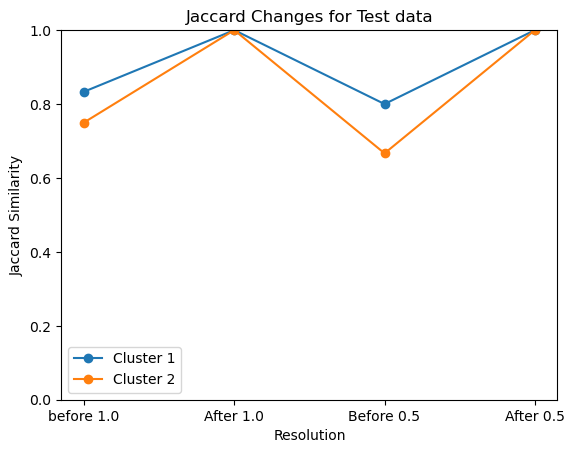

In [81]:
fig, ax  = plt.subplots()
for i in range(0, len(coarse_modules)):
    ax.plot(jaccard_track.columns, jaccard_track.iloc[i], marker = "o", label=f'Cluster {i+1}')

ax.set_ylim(0, 1.0)
ax.legend()
ax.set_ylabel('Jaccard Similarity')
ax.set_xlabel('Resolution')
ax.set_title('Jaccard Changes for Test data')

In [83]:
# 

(      0.0  0.5  1.0
 id                 
 1000    1    1    1
 2000    1    1    2
 3000    1    1    3
 8000    2    3    7,
       0.0  0.5  1.0
 id                 
 1000    1    1    1
 2000    1    1    2
 3000    1    1    3
 4000    1    2    4
 5000    1    2    5
 6000    2    2    6
 7000    2    2    5
 8000    2    3    7)

In [95]:
# Import data
df_in1 = pd.read_csv('oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv', index_col=0)
df_in1

,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
id,,,,,,,,,,,,,,,,,,,,,
1003215282,1,1,1,1,1,1,1,CL229_R,CL229,100,...,Traced,False,Roughly traced,PDM19,301.0,"[23044, 14981, 11600]","{'INP': {'pre': 87, 'post': 351, 'downstream':...",NaN,"['EPA(R)', 'GOR(R)', 'IB', 'ICL(R)', 'INP', 'S...","['GOR(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1005952640,2,2,1,1,2,2,2,IB058_R,IB058,664,...,Traced,False,Roughly traced,PVL20,NaN,NaN,"{'INP': {'pre': 464, 'post': 1327, 'downstream...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S..."
1006928515,3,1,1,1,3,3,3,CL300_R,CL300,86,...,Traced,False,Roughly traced,PVL13,236.0,"[12083, 10523, 16816]","{'INP': {'pre': 79, 'post': 126, 'downstream':...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1007260806,4,2,1,1,4,4,4,CL301_R,CL301,119,...,Traced,False,Roughly traced,PVL13,236.0,"[13524, 10108, 16480]","{'INP': {'pre': 40, 'post': 128, 'downstream':...",NaN,"['GOR(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['IB', 'ICL(R)', 'INP', 'PLP(R)', 'SCL(R)', 'S..."
1008024276,5,3,2,2,5,5,5,FB5N_R,FB5N,499,...,Traced,False,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987273073,2507,3,8,8,409,604,629,(PVL05)_L,None,283,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(R)': {'pre': 65, 'post': 52, 'downstream...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."
987842109,2508,3,9,23,533,780,815,None,None,2,...,Orphan,NaN,Orphan hotknife,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 13, 'downstream'...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"
988567837,2509,2,3,4,16,58,63,FB4G_R,FB4G,785,...,Traced,False,Roughly traced,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 6, 'post': 73, 'downstream'...",CRELALFB4_3,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."


In [104]:
# Filter to just cluster 1


# Coarse modules
coarse_modules1 = [1,2,3,4,5]
chi_values = ['1.0', '0.75', '0.5', '0.1', '0.05']
filtered_df1, jaccard_values1, jaccard_track1 = pillar_finder(df_in1, coarse_modules1, chi_values)

dict_keys([1, 2, 3, 4, 5])
dict_keys([1, 2, 3, 4, 5])
[1008024276, 1008391068, 1039068185, 1039400642, 1070422316, 1071121755, 1164545788, 1257629175, 486842208, 5813011125, 5813060701, 5813061260, 5813076043, 5813081864, 881220948, 890671753, 915960293, 977339225, 1008369339, 1044805646, 1075611602, 5813014391, 701345660, 826659627, 1008693605, 1010437434, 1035393986, 1106888382, 5813057464, 882239837, 947685653, 982070626, 1009371535, 1014465452, 1009578838, 296859399, 298262599, 298603633, 361363973, 514474716, 575323308, 580071186, 828282250, 1010044978, 5812986798, 1013066710, 5813105778, 1013757060, 1013779115, 1076198559, 1107566171, 1107566252, 1292083252, 5812989861, 763086729, 1014102651, 1014223948, 1014461486, 1014474192, 1041071176, 1044918145, 1071496918, 1071760480, 1072779298, 1134849078, 1136252170, 1195891557, 329983926, 514807275, 578936675, 5813014693, 5813022923, 5813055999, 607933758, 640665331, 705463539, 732059827, 890425079, 915273417, 940791248, 983067799, 983

In [108]:

jaccard_track1.columns = ['before 1.0', 'After 1.0', 'Before 0.75', 'After 0.75', 'Before 0.5', 'After 0.5', 'Before 0.1', 'After 0.1', 'Before 0.05', 'After 0.05']
jaccard_track1

,before 1.0,After 1.0,Before 0.75,After 0.75,Before 0.5,After 0.5,Before 0.1,After 0.1,Before 0.05,After 0.05
1,0.641533,1.0,0.934132,1.0,0.857143,1.0,0.430830,1.0,0.476190,1.0
2,0.793792,1.0,0.778309,1.0,0.879852,1.0,0.503429,1.0,0.964539,1.0
3,0.680974,1.0,0.949339,1.0,0.693237,1.0,0.483235,1.0,0.974359,1.0
4,0.563433,1.0,0.928251,1.0,0.766667,1.0,0.254464,1.0,0.625000,1.0
5,0.569956,1.0,0.950413,1.0,0.788889,1.0,0.269891,1.0,0.980392,1.0


In [141]:
jaccard_values_ins

,0.05,0.1,0.5,0.75,1.0
1,0.239281,0.264661,0.607018,0.683794,0.641533
2,0.380649,0.385984,0.576026,0.695821,0.793792
3,0.334855,0.268037,0.563881,0.702153,0.680974
4,0.187461,0.155031,0.483200,0.680180,0.563433
5,0.236408,0.215839,0.507208,0.651515,0.569956


Text(0.5, 1.0, 'Jaccard Changes for Input data')

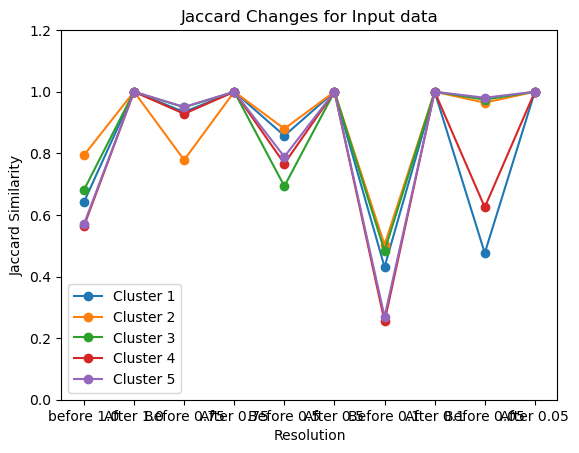

In [112]:
# plot
fig, ax  = plt.subplots()
for i in range(0, len(coarse_modules1)):
    ax.plot(jaccard_track1.columns, jaccard_track1.iloc[i], marker = "o", label=f'Cluster {i+1}')

ax.set_ylim(0, 1.2)
ax.legend()
ax.set_ylabel('Jaccard Similarity')
ax.set_xlabel('Resolution')
ax.set_title('Jaccard Changes for Input data')

In [113]:
filtered_df1

,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
id,,,,,,,,,,,,,,,,,,,,,
1013757060,25,3,2,2,19,19,19,PLP042_b_R,PLP042_b,86,...,Traced,False,Roughly traced,AVL04,261.5,"[28, 25295, 20152]","{'SNP(R)': {'pre': 27, 'post': 91, 'downstream...",Pl-C,"['AOT(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP', 'LAL(-G..."
1013779115,26,3,2,2,19,19,19,FC1C(FQ6)_C9_L,FC1C,87,...,Traced,False,Roughly traced,PDM04,275.0,"[32908, 11191, 19696]","{'SNP(R)': {'pre': 37, 'post': 27, 'downstream...",FB2CRE,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
1036503560,52,2,7,10,31,35,35,LHPV3a1_R,LHPV3a1,229,...,Traced,False,Roughly traced,PVL10,286.0,"[2035, 16392, 14088]","{'SNP(R)': {'post': 3, 'upstream': 3}, 'SLP(R)...",NaN,"['AVLP(R)', 'EPA(L)', 'EPA(R)', 'GC', 'INP', '...","['AVLP(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'EP..."
1066516552,96,3,2,2,19,60,65,PLP042_b_R,PLP042_b,80,...,Traced,False,Roughly traced,AVL04,291.5,"[468, 25475, 20836]","{'SNP(R)': {'pre': 6, 'post': 32, 'downstream'...",Pl-C,"['AOT(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP...","['AOT(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP..."
1068436695,97,2,7,7,51,61,66,IB079(PVM03)_L,IB079,249,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(L)': {'pre': 1, 'post': 19, 'downstream'...",NaN,"['ATL(L)', 'GOR(L)', 'IB', 'ICL(L)', 'INP', 'L...","['GOR(L)', 'IB', 'INP', 'LAL(-GA)(R)', 'LAL(R)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956518968,2460,2,7,7,500,737,783,LAL200(SCB015)_R,LAL200,1086,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(R)': {'pre': 1, 'post': 120, 'downstream...",NaN,"['ATL(L)', 'ATL(R)', 'CAN(R)', 'CRE(-ROB,-RUB)...","['ATL(L)', 'ATL(R)', 'CRE(-ROB,-RUB)(R)', 'CRE..."
977339122,2468,3,2,2,5,527,525,FB5L_R,FB5L,749,...,Traced,False,Roughly traced,AVM08,451.5,"[20556, 29411, 36600]","{'SNP(R)': {'pre': 8, 'post': 104, 'downstream...",CRESMPFB5_4,"['BU(L)', 'BU(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R...","['BU(L)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX',..."
983767417,2495,2,7,7,31,752,134,LAL175_R,LAL175,116,...,Traced,False,Roughly traced,PVM03,335.0,"[17040, 9200, 20880]","{'SNP(R)': {'pre': 1, 'post': 13, 'downstream'...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP', 'LAL(-G...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP', 'LAL(-G..."


In [114]:
# cluster 1
cluster1 = filtered_df1[filtered_df1['0.0']==1]
cluster1

,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
id,,,,,,,,,,,,,,,,,,,,,
825182392,2227,1,85,73,489,729,774,None,None,2,...,Assign,NaN,0.5assign,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 4, 'downstream':...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"
920708433,2400,1,93,85,519,761,805,None,None,2,...,Assign,NaN,0.5assign,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 2, 'downstream':...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"
953103667,2455,1,98,88,527,773,816,None,None,2,...,Assign,NaN,0.5assign,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 5, 'downstream':...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"
985510931,2501,1,101,89,531,777,820,None,None,2,...,Assign,NaN,0.5assign,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 5, 'downstream':...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"


In [115]:
# cluster 2
cluster2 = filtered_df1[filtered_df1['0.0']==2]
cluster2

,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
id,,,,,,,,,,,,,,,,,,,,,
1036503560,52,2,7,10,31,35,35,LHPV3a1_R,LHPV3a1,229,...,Traced,False,Roughly traced,PVL10,286.0,"[2035, 16392, 14088]","{'SNP(R)': {'post': 3, 'upstream': 3}, 'SLP(R)...",NaN,"['AVLP(R)', 'EPA(L)', 'EPA(R)', 'GC', 'INP', '...","['AVLP(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'EP..."
1068436695,97,2,7,7,51,61,66,IB079(PVM03)_L,IB079,249,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(L)': {'pre': 1, 'post': 19, 'downstream'...",NaN,"['ATL(L)', 'GOR(L)', 'IB', 'ICL(L)', 'INP', 'L...","['GOR(L)', 'IB', 'INP', 'LAL(-GA)(R)', 'LAL(R)..."
1068777508,98,2,7,7,52,62,67,IB070(PVM03)_L,IB070,179,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(L)': {'post': 26, 'upstream': 26, 'mito'...",NaN,"['ATL(L)', 'ATL(R)', 'CRE(-ROB,-RUB)(R)', 'CRE...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'IB', 'INP', '..."
1069002537,99,2,7,7,53,63,68,LAL009_R,LAL009,783,...,Traced,False,Roughly traced,ADM03,292.5,"[14658, 32516, 11040]","{'INP': {'pre': 52, 'post': 799, 'downstream':...",IbSp-L,"['ATL(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'EPA...","['ATL(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'IB'..."
1081957306,129,2,7,7,61,74,83,CRE041_R,CRE041,533,...,Traced,False,Roughly traced,ADM10,328.5,"[20477, 32431, 7696]","{'SNP(R)': {'pre': 54, 'post': 2108, 'downstre...",CL-L(c)2,"['AOTU(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'IN...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP', 'LAL(-G..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925241334,2419,2,3,7,107,191,190,LAL155_R,LAL155,604,...,Traced,False,Roughly traced,PVM03,335.0,"[19491, 8903, 21888]","{'SNP(L)': {'pre': 166, 'post': 82, 'downstrea...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."
952374245,2450,2,7,7,95,119,127,LAL114_R,LAL114,573,...,Traced,False,Roughly traced,AVM17,396.5,"[12213, 34025, 26496]","{'SNP(R)': {'pre': 53, 'post': 44, 'downstream...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."
956518968,2460,2,7,7,500,737,783,LAL200(SCB015)_R,LAL200,1086,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(R)': {'pre': 1, 'post': 120, 'downstream...",NaN,"['ATL(L)', 'ATL(R)', 'CAN(R)', 'CRE(-ROB,-RUB)...","['ATL(L)', 'ATL(R)', 'CRE(-ROB,-RUB)(R)', 'CRE..."


In [124]:
# cluster 3
cluster3 = filtered_df1[filtered_df1['0.0']==3]
cluster3

,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
id,,,,,,,,,,,,,,,,,,,,,
1013757060,25,3,2,2,19,19,19,PLP042_b_R,PLP042_b,86,...,Traced,False,Roughly traced,AVL04,261.5,"[28, 25295, 20152]","{'SNP(R)': {'pre': 27, 'post': 91, 'downstream...",Pl-C,"['AOT(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP', 'LAL(-G..."
1013779115,26,3,2,2,19,19,19,FC1C(FQ6)_C9_L,FC1C,87,...,Traced,False,Roughly traced,PDM04,275.0,"[32908, 11191, 19696]","{'SNP(R)': {'pre': 37, 'post': 27, 'downstream...",FB2CRE,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
1066516552,96,3,2,2,19,60,65,PLP042_b_R,PLP042_b,80,...,Traced,False,Roughly traced,AVL04,291.5,"[468, 25475, 20836]","{'SNP(R)': {'pre': 6, 'post': 32, 'downstream'...",Pl-C,"['AOT(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP...","['AOT(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP..."
1070103072,100,3,2,2,54,64,69,FS1B(FQ9)_C5_R,FS1B,93,...,Traced,False,Roughly traced,PDM02,236.0,"[20163, 12299, 13792]","{'SNP(L)': {'pre': 50, 'post': 15, 'downstream...",FB25SMPSMP,"['CX', 'FB', 'FBl2', 'FBl3', 'FBl4', 'FBl5', '...","['SMP(L)', 'SMP(R)', 'SNP(L)', 'SNP(R)']"
1072503099,113,3,2,2,19,69,76,FC1E(FQ6)_C6_L,FC1E,127,...,Traced,False,Roughly traced,PDM03,299.0,"[30426, 15829, 7848]","{'SNP(R)': {'pre': 11, 'post': 1, 'downstream'...",FB2CRE,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
1076198559,126,3,2,2,19,19,19,FC1C(FQ6)_C8_L,FC1C,89,...,Traced,False,Roughly traced,PDM04,246.0,"[31329, 10625, 18040]","{'SNP(R)': {'pre': 21, 'post': 11, 'downstream...",FB2CRE,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
1100801188,133,3,2,2,5,76,86,FB4D_R,FB4D,379,...,Traced,False,Roughly traced,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 12, 'post': 204, 'downstrea...",CRESMPFB4_2,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
1101142083,134,3,2,2,19,19,65,FC1C(FQ6)_C5_L,FC1C,108,...,Traced,False,Roughly traced,PDM02,291.0,"[31603, 15730, 12576]","{'SNP(R)': {'pre': 30, 'post': 16, 'downstream...",FB2CRE,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
1102191395,136,3,2,2,63,77,87,FB5P_R,FB5P,259,...,Traced,False,Roughly traced,AVM10,292.5,"[11565, 32533, 18104]","{'SNP(R)': {'pre': 6, 'post': 353, 'downstream...",SMPCREFB5_6,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."


In [122]:
# cluster 2 checks
from util import *
import plotly.graph_objects as go
# Function for creating the sankey diagram
def create_sankey(df, chis, prominent=False, prom_types=None, figsize=None, title=None):
    """This function creates a sankey diagram from the data in the dataframe df.
    The columns to be used are in the list chis. If prominent is True, then only 
    the prominent types are used.
    
    df: dataframe with partition data
    chis: list of chi values in modularity data
    prominent: boolean, whether to use only prominent types
    prom_types: dataframe of prominent types and their weights, columns are 'type_pre' and 'weight'
    FigSize: int of figure size

    Returns: Sankey Figure
    """
    # prominent types only option:
    if prominent:
        ovi_chunk_df = df[df['celltype'].isin(prom_types['type_pre'])]

        # Take only the columns that are needed
        ovi_chunk_df = ovi_chunk_df[chis]
    
    else:
        ovi_chunk_df = df[chis]

    # Append correct _r values to the columns
    for i, x in enumerate(chis):
        ovi_chunk_df[x] = ovi_chunk_df[x].astype(str) + '_r' + str(x)

    # add a column of ones to ovi_HB_chunk
    ovi_chunk_df['counts'] = 1

    # Creating list of all nodes for diagram
    nodes = ovi_chunk_df['0.0'].unique().tolist() \
                + ovi_chunk_df['0.05'].unique().tolist() \
                + ovi_chunk_df['0.1'].unique().tolist() \
                + ovi_chunk_df['0.5'].unique().tolist() \
                + ovi_chunk_df['0.75'].unique().tolist() \
                + ovi_chunk_df['1.0'].unique().tolist() 

    # Finding the links 
    df1 = ovi_chunk_df.groupby(['0.0','0.05'])['counts'].count().reset_index().rename(columns={'0.0':'source','0.05':'target','counts':'value'})
    df2 = ovi_chunk_df.groupby(['0.05','0.1'])['counts'].count().reset_index().rename(columns={'0.05':'source','0.1':'target','counts':'value'})
    df4 = ovi_chunk_df.groupby(['0.1','0.5'])['counts'].count().reset_index().rename(columns={'0.1':'source','0.5':'target','counts':'value'})
    df5 = ovi_chunk_df.groupby(['0.5','0.75'])['counts'].count().reset_index().rename(columns={'0.5':'source','0.75':'target','counts':'value'})
    df6 = ovi_chunk_df.groupby(['0.75','1.0'])['counts'].count().reset_index().rename(columns={'0.75':'source','1.0':'target','counts':'value'})

    # Concatenate all the dataframes
    links = pd.concat([df1, df2, df4, df5, df6], axis=0)

    mapping_dict = {k: v for v, k in enumerate(nodes)}

    # replace source and target with mapping dictionary
    links['source'] = links['source'].map(mapping_dict)
    links['target'] = links['target'].map(mapping_dict)

    # turn this table into a dictionary for making the sankey diagram
    links_dict = links.to_dict(orient='list')

    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness=20,
            line=dict(width=0.5),
            label = nodes,
        ),
        link = dict(
            source= links_dict['source'],
            target = links_dict['target'],
            value = links_dict['value']
        )
        )
    ])
    # make figure larger
    fig.update_layout(height = figsize, width= 1000, title=title)
    fig.show()

In [123]:
create_sankey(cluster2, ['0.0', '0.05', '0.1', '0.5', '0.75', '1.0'], figsize=800, title='Sankey Diagram for Cluster 2')

/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_2566/3653319706.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ovi_chunk_df[x] = ovi_chunk_df[x].astype(str) + '_r' + str(x)
/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_2566/3653319706.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ovi_chunk_df['counts'] = 1
